# Experiments

In [1]:
import os 

print(os.sys.path)

['E:\\Tim\\doctorate\\OpenAFQA_dev\\experiments', 'C:\\Users\\Panter\\anaconda3\\envs\\qa\\python38.zip', 'C:\\Users\\Panter\\anaconda3\\envs\\qa\\DLLs', 'C:\\Users\\Panter\\anaconda3\\envs\\qa\\lib', 'C:\\Users\\Panter\\anaconda3\\envs\\qa', '', 'C:\\Users\\Panter\\anaconda3\\envs\\qa\\lib\\site-packages', 'e:\\tim\\doctorate\\openafqa_dev', 'C:\\Users\\Panter\\anaconda3\\envs\\qa\\lib\\site-packages\\win32', 'C:\\Users\\Panter\\anaconda3\\envs\\qa\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Panter\\anaconda3\\envs\\qa\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Panter\\anaconda3\\envs\\qa\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Panter\\.ipython']


In [2]:
# IMPORT CODE 
import os 
import cv2
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.model_selection import RandomizedSearchCV
from IPython import display
from PIL import Image


def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks.
  Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
      (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
      image.
  """
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display.display(Image.fromarray(a))

def load_data(location, labels, metric):
    fv_list = os.listdir(location)
    fv_nb = len(fv_list)

    with open(location + fv_list[0], "rb") as handle: 
        fv0 = pickle.load(handle)

    with open(labels, "rb") as handle: 
        labels = pickle.load(handle)

    print("Number of vectors: " + str(fv_nb) + " of length " + str(len(fv0)))

    data_x = np.zeros(shape=(fv_nb, len(fv0)))
    data_y = np.zeros(shape=(fv_nb,))

    for i, fv_filename in enumerate(fv_list): 
        with open(location + fv_filename, "rb") as handle: 
            fv = pickle.load(handle)
        
        fid = fv_filename.split(".")[0]

        data_y[i] = 0
        if metric in labels[fid]: 
            data_y[i] = labels[fid][metric] 

        data_x[i] = fv

    return data_x, data_y, fv_list


In [41]:
DATA_FOLDER = "D:\\NIST datasets\\feature_vector_dataset\\"
#DATA_FOLDER = "/home/tim/data/feature_vector_dataset/"

LABELS = DATA_FOLDER + "qualities_v2.pkl"
metric = "vfq"

train_x, train_y, train_names = load_data(DATA_FOLDER + "train/", LABELS, metric)
test_x, test_y, test_names = load_data(DATA_FOLDER + "test/", LABELS, metric)

Number of vectors: 12000 of length 192
Number of vectors: 1200 of length 192


In [4]:

n_estimators = [int(x) for x in np.linspace(start=50, stop=1050, num = 11)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 150, num = 15)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2]#, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]#, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True ]#, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'verbose': [True],
               'n_jobs': [2]}

print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=5, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(train_x, train_y)

print(rf_random.best_params_)


{'n_estimators': [50, 150, 250, 350, 450, 550, 650, 750, 850, 950, 1050], 'max_features': ['auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, None], 'min_samples_split': [2], 'min_samples_leaf': [1], 'bootstrap': [True], 'verbose': [True], 'n_jobs': [2]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   48.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  3.3min


{'verbose': True, 'n_jobs': 2, 'n_estimators': 1050, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 140, 'bootstrap': True}


[Parallel(n_jobs=2)]: Done 1050 out of 1050 | elapsed:  4.3min finished


In [42]:
#VFQ
regr = RandomForestRegressor(n_estimators=750, max_depth=150, min_samples_split=2, min_samples_leaf=1, random_state=0, verbose=True, n_jobs=8)

#LQM
#regr = RandomForestRegressor(n_estimators=1050, max_depth=140, min_samples_split=2, min_samples_leaf=1, random_state=0, verbose=True, n_jobs=8)

#NFIQ2
#regr = RandomForestRegressor(n_estimators=750, max_depth=30, min_samples_split=2, min_samples_leaf=1, random_state=0, verbose=True, n_jobs=8)

regr.fit(train_x, train_y)

train_predictions = np.clip(regr.predict(train_x), 0, 100)
predictions = np.clip(regr.predict(test_x), 0, 100)

print("train MSE", mean_squared_error(train_y, train_predictions))
print("test MSE", mean_squared_error(test_y, predictions))

print("train MAE", mean_absolute_error(train_y, train_predictions))
print("test MAE", mean_absolute_error(test_y, predictions))

print("train R2", r2_score(train_y, train_predictions))
print("test R2", r2_score(test_y, predictions))


import pickle
with open("rf_model_nfq.pkl", "wb") as handle: 
    pickle.dump(regr, handle)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   19.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   46.3s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished


train MSE 4.97562368237037
test MSE 41.455495874074074
train MAE 1.6685184444444445
test MAE 4.838034444444444
train R2 0.9897930961918455
test R2 0.6850506428191442


In [43]:
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance


features = ["Mean",    "STD",    "Orient",    "OCL",    "RDI",    "S3PG",    "PES",    "MOW",    "ACUT",    "SF",    "FDA",    "LCS",    "RVU",    "OFL",    "GAB"]
indi = ["mean",    "std",    "bin_0",    "bin_1",    "bin_2",    "bin_3",    "bin_4",    "bin_5",    "bin_6",    "bin_7",    "bin_8",    "bin_9"]
min_indi = ["mean",    "num",    "bin_0",    "bin_1",    "bin_2",    "bin_3",    "bin_4",    "bin_5",    "bin_6",    "bin_7", "bin_8", "bin_9"]

feature_names = []
for f in features:
    for ind in indi:  
        feature_names.append(f + " " + ind)


for ind in min_indi:  
    feature_names.append("Minu " + ind)

    
result = permutation_importance(regr, test_x, test_y, n_repeats=10, random_state=42, n_jobs=2)
importances2 = result.importances_mean 
stds2 = result.importances_std



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:    0.0s finished


['Mean' 'GAB' 'ACUT' 'S3PG' 'OFL' 'Orient' 'STD' 'PES' 'RVU' 'RDI' 'MOW'
 'LCS' 'SF' 'OCL' 'FDA' 'Minu']


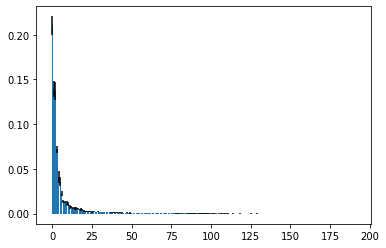

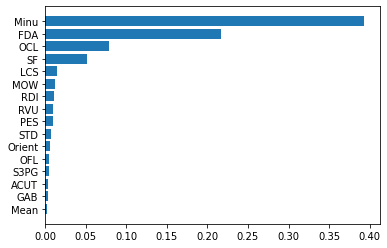

In [44]:
feature_names = np.array(feature_names)


idxs = np.argsort(importances2)[::-1]
simp = importances2[idxs]
sstd = stds2[idxs]

f_sum = []
for f, fname in enumerate(features + ["Minu"]):
    curr_sum = 0
    for i in range(12):
        curr_sum += importances2[12*f + i]
    f_sum.append(curr_sum)

fnames = np.array(features + ["Minu"])
f_sum = np.array(f_sum)
indices = np.argsort(f_sum)

print(fnames[indices])
        
fig, ax = plt.subplots()
plt.bar(range(0, len(simp)), simp, yerr=sstd)

fig, ax = plt.subplots()
plt.barh(range(0, len(f_sum)), f_sum[indices])
ax.set_yticks(range(0, len(f_sum)))
ax.set_yticklabels(fnames[indices])

plt.show()

25.998142222222224
Crossing at: 24.730382607198766


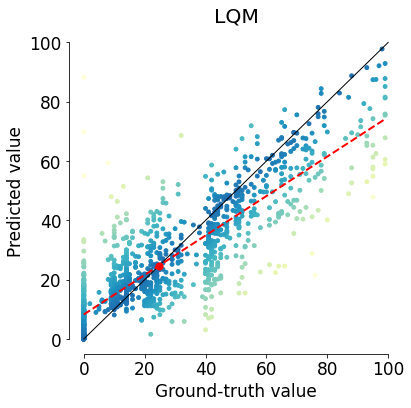

In [89]:
import matplotlib
from matplotlib import pyplot as plt

IMAGE_FOLDER = "/home/tim/data/SD301/images/latent/png/"

font = {'family' : 'Arial',
        'weight' : 'medium',
        'size'   : 17}

matplotlib.rc('font', **font)

args = np.argsort(test_y)

sorted_gt = test_y[args]
sorted_p = predictions[args]
tn = np.array(test_names)[args]
diffs = sorted_p - sorted_gt
print(sorted_p.mean())
#args = np.argsort(diffs)
#diff_diffs = diffs[args]
#diff_gt = sorted_gt[args]
#diff_p = sorted_p[args]
#diff_tn = tn[args]

#for i, name in enumerate(diff_tn[:50]): 
#    print(diff_diffs[i])
    
#    image = cv2.imread(IMAGE_FOLDER + name.split(".")[0] + ".png", 0)
#    image = cv2.resize(image, (512, 512))
    
#    image = cv2.copyMakeBorder(image, 0, 50, 0, 0, cv2.BORDER_CONSTANT, value=0)
#    image = cv2.putText(image, "Predicted: " + str(round(diff_p[i], 2)), (5, 532), cv2.FONT_HERSHEY_DUPLEX, 0.5, 255)
#    image = cv2.putText(image, "Ground-truth: " + str(diff_gt[i]), (5, 552), cv2.FONT_HERSHEY_DUPLEX, 0.5, 255)
#    cv2_imshow(image)



model = "LQM"
fig, ax = plt.subplots(figsize=(6,6))

plt.rc("axes.spines", top=False, right=False, left=True, bottom=True )
ax.spines.left.set_bounds((0, 100))
ax.spines.bottom.set_bounds((0, 100))
#plt.rc("axes.spines.right.bounds") 



plt.xlabel("Ground-truth value")
plt.ylabel("Predicted value")
plt.scatter(sorted_gt, sorted_p, c=-np.abs(diffs), s=15, cmap="YlGnBu", vmin=-50, vmax=20)
plt.title(model)
plt.xlim([-5, 105])
plt.ylim([-5, 105]) #sorted_p.max()+5])


m, b = np.polyfit(sorted_gt, sorted_p, 1)


print("Crossing at:", b/(1-m))
cpoint = b/(1-m)


plt.plot([0, 100], [0, 100], color="black", linewidth=1)
plt.plot(sorted_gt, m*sorted_gt + b, color="red", 
         linestyle='dashed', linewidth=2)


#e6332a red
#028a38 green
plt.scatter([cpoint], [cpoint], color="red", s=51, zorder=5)
plt.show()

fig.savefig(model + "_dashed.svg", bbox_inches='tight')

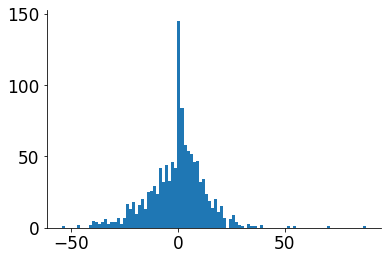

In [92]:


plt.hist(diffs, bins=100)

plt.show()